### Assessment of interference  - are MASCARA images affected by Starlink trails?

MASCARA science case - detecting transiting exoplanets!

4 things to investigate:

1. Stars
2. Exoplanets
3. Rubin Field
4. Naked eye

1st point; how many stars are affected by trails? Check if a trail is within the annulus used to select stars. If a trail is within a single annulus, then can say that stars could be affected. Do this for specific periods of the night i.e. at different illuminations, when sun is at a certain elevation etc etc.

2nd point; FOV for explanets only a few arcsec, so there's a chance a trail will cover it. Chance will be small but we can expand this to future population sizes.

3rd point; get clarification!

4th point; probability of seeing with the naked eye .. get clarification!

In [1]:
import os
import glob
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

import astropy.stats as aps
import astropy.io.fits as pf
from astropy.time import Time

from skyfield.units import Angle
from skyfield.api import load, wgs84, EarthSatellite 
    

rootdir = '/Users/peter/Projects/starlink_data/'
datadir = rootdir + 'full_data/'
testdir = rootdir + 'test_data/'
savedir = rootdir + 'images/results/'


starlink_ref = pd.read_pickle(f'{rootdir}starlink_names.p')


eph = load('de421.bsp')

Masked image used for the flux of the satellite track. In case the satellite passes in front of a star, we do not want to erroneously count the flux of the star towards the satellite:

`sattrack = self.maskedstarimage[np.where(sat_mask==1)]`

We select surrounding stars that lie within circle with r = 2*line length of the center of the line segment (a,b). In summary, this code segment calculates the center point of a line segment and selects stars that are located within a circular region around that line segment based on their coordinates and magnitude.

Calculate the center point (a,b) of line segment by taking the average of the min and max values of (x,y)

`a,b = int(round((x_min+x_max)/2.)), int(round((y_min+y_max)/2.))`

Create a meshgrid, these arrays represent the coords of all the pixels in the emptymask array

`yy, xx = np.meshgrid(np.linspace(0, emptymask.shape[0]-1, emptymask.shape[0]), np.linspace(0, emptymask.shape[1]-1, emptymask.shape[1]))`

`starsmask = emptymask.copy()`


Calculate the distances of each pixel in the xx and yy arrays from the center point (a,b) using the distance formula (xx-a)^2 + (yy-b)^2. Then update the starsmask by setting the value to 1 for all pixels that lie within a circle with a radius equal to 2*n_pixels around the center point (a,b). This is done by finding the indices where the calculated distances are less than or equal to (4*n_pixels*n_pixels).

`starsmask[np.where((xx-a)**2.+(yy-b)**2. <= (4*n_pixels*n_pixels))[1], np.where((xx-a)**2.+(yy-b)**2. <= (4*n_pixels*n_pixels))[0]] = 1`


The updated starsmask is then used to select stars by checking if the rounded stars_x0, stars_y0 coords of stars exist in the indices of starsmask where the value is 1. Additionally, it filters the stars based on their magnitude (vmag) and the value of n_pixels. Only stars with vmag less than or equal to 9.0 are selected. The selected stars are stored in the select_stars variable, which contains the indices of the selected stars.

`select_stars = np.where(np.in1d(np.round(self.stars_x0).astype(int), np.argwhere(starsmask==1)[:,1]) & np.in1d(np.round(self.stars_y0).astype(int), np.argwhere(starsmask==1)[:,0]) & (self.starcat['vmag'][self.stars_err0] <= 9.0))[0]`


In [2]:
def get_siteinfo():
    confdir = '/Users/Peter/Projects/starlink_data/fotos-python3/bringfiles/siteinfo.dat'
    dtype = [('sitename', '|U20'), ('lat', 'float32'), ('lon', 'float32'), ('height', 'float32'), ('ID', '|U2')]
    siteinfo = np.genfromtxt(confdir, dtype=dtype)   
    mask = siteinfo['ID'] == 'LS'
    siteinfo = siteinfo[mask]
    return siteinfo


def createmask(masksize = 4):
    lingrid = np.linspace(0, masksize*2, masksize*2+1)-masksize
    xx, yy = np.meshgrid(lingrid,lingrid)
    rr = np.sqrt(xx**2+yy**2)
    mask = np.zeros((masksize*2+1,masksize*2+1))
    mask[np.where(rr <= (masksize+0.1))] = 1
    return mask        


def createring(radius = 200, dr=.1):
    #if dr < 1, then the ring width is a fraction of the ring radius. Otherwise ringwidth is set by value of dr. 
    if dr < 1:
        masksize = int((1+dr)*radius)
    else:
        masksize = radius+dr
    lingrid = np.linspace(0, masksize*2, masksize*2+1)-masksize
    xx, yy = np.meshgrid(lingrid,lingrid)
    rr = np.sqrt(xx**2+yy**2)
    mask = np.zeros((masksize*2+1,masksize*2+1))
    mask[np.where((rr>=radius)&(rr <= (masksize+0.1)))] = 1
    return mask 


def remove_badpixel_lines():

    lines = alllines.copy()
    lines = lines.reshape(lines.shape[0],lines.shape[2])

    if camid in badpixelareas.keys():
        for badarea in np.arange(len(badpixelareas[camid])):
            indices = (np.logical_and(badpixelareas[camid][badarea][0]<=lines[:,0], 
                                      lines[:,0]<=badpixelareas[camid][badarea][1]))*\
            (np.logical_and(badpixelareas[camid][badarea][0]<=lines[:,2], 
                            lines[:,2]<=badpixelareas[camid][badarea][1]))*\
            (np.logical_and(badpixelareas[camid][badarea][2]<=lines[:,1], 
                            lines[:,1]<=badpixelareas[camid][badarea][3]))*\
            (np.logical_and(badpixelareas[camid][badarea][2]<=lines[:,3], 
                            lines[:,3]<=badpixelareas[camid][badarea][3]))
            lines=lines[np.logical_not(indices)]
    alllines = lines

In [3]:
import os
import sys
import cv2
import h5py
import matplotlib
import numpy as np
import astropy.stats as aps
import scipy.ndimage as scn
from astropy.time import Time
from astropy import units as u
import matplotlib.pyplot as plt
from sklearn import linear_model
from scipy.optimize import curve_fit
from astropy.coordinates import EarthLocation, get_moon

import logging
logging.captureWarnings(True)


def LineSegments(fast, deltaimage, nx, ny, starcat, astrometry):

    mean, median, sigma = aps.sigma_clipped_stats(np.abs(deltaimage))
    curastro = np.where((fast['astrometry/lstseq'][:] // 50) == (curlstseq // 50))[0][0]
    order = fast['astrometry/x_wcs2pix'][curastro].shape[0]-1
    astrolst = fast['station/lst'][np.where(fast['station/lstseq'][:] == (
        fast['astrometry/lstseq'][curastro]))[0][0]]
    astrolstseq = fast['station/lstseq'][np.where(fast['station/lstseq'][:] == (
        fast['astrometry/lstseq'][curastro]))[0][0]]

    wcspars = { 'crval' : fast['astrometry/crval'][curastro].copy(),
                'crpix' : fast['astrometry/crpix'][curastro].copy(),
                'cdelt' : [0.02148591731740587,0.02148591731740587],
                'pc'    : fast['astrometry/pc'][curastro].copy(),
                'lst'   : astrolst}
    polpars = { 'x_wcs2pix' : fast['astrometry/x_wcs2pix'][curastro].copy(),
                'y_wcs2pix' : fast['astrometry/y_wcs2pix'][curastro].copy(),
                'x_pix2wcs' : fast['astrometry/x_pix2wcs'][curastro].copy(),
                'y_pix2wcs' : fast['astrometry/y_pix2wcs'][curastro].copy(),
                'nx'    : nx,
                'ny'    : ny,
                'order' : order}

    astro = astrometry.Astrometry(wcspars, polpars)
        
    ra, dec = starcat['_raj2000'], starcat['_dej2000']
    stars_x0, stars_y0, stars_err0 = astro.world2pix(midlst,ra,dec,jd=midJD)
    select = np.where(
        (stars_x0 > edge) & 
        (stars_y0 > edge) & 
        (stars_x0 < (nx-edge)) & 
        (stars_y0 < (ny-edge)) & 
        (starcat['vmag'][stars_err0] <= 9.0))[0]
    xxx, yyy = np.round(stars_x0[select]).astype(int), np.round(stars_y0[select]).astype(int)
    vmag = starcat['vmag'][select]
                
    badpixelareas = {'SAE':[[50, 150, 600, 950]], 'AUE':[[0,300,1750, 2720],[3400, 4072, 0, 350]], 
                     'LSE':[], 'LSS':[], 'LSW':[[0,350,2350,2720]], 'LSN':[], 'LSC':[]}
    image_id = str(curlstseq)
    MooninImage = False
    
    return astro, vmag, deltaimage, masksizes, xxx, yyy, stars_x0, stars_y0, stars_err0

In [4]:
def ImageReduction(astro, siteinfo, JD, moonmargin=400):
    
    mean, median, sigma = aps.sigma_clipped_stats(np.abs(deltaimage))

    nostarimage = deltaimage.copy()
    mask = [createmask(ms) for ms in masksizes]

    #The size of the mask depends on the brightness of the star
    for ccc in range(len(yyy)):
        curmask = -1
        if ((vmag[ccc] < 6) & (vmag[ccc] >= 4.5)):
            curmask = 0
        if ((vmag[ccc] < 4.5) & (vmag[ccc] >= 2.5)):
            curmask = 2
        elif (vmag[ccc] < 2.5):
            curmask = 3
        if curmask >=0:
            nostarimage[yyy[ccc]-masksizes[curmask]:yyy[ccc]+masksizes[curmask]+1,
                        xxx[ccc]-masksizes[curmask]:xxx[ccc]+masksizes[curmask]+1] = nostarimage[
                yyy[ccc]-masksizes[curmask]:yyy[ccc]+masksizes[curmask]+1,
                        xxx[ccc]-masksizes[curmask]:xxx[ccc]+masksizes[curmask]+1]*(
                1-mask[curmask])+ median*mask[curmask]


    #Check if the Moon is in FoV of camera
    observatory = EarthLocation(lat=siteinfo['lat']*u.deg, 
                                lon=siteinfo['lon']*u.deg, 
                                height=siteinfo['height']*u.m)       
    gcrs_coords = get_moon(Time(JD, format='jd'), location=observatory)

    moonx_astropy, moony_astropy, moon_mask = astro.world2pix(
        midlst, gcrs_coords.ra.value[0], gcrs_coords.dec.value[0], jd=midJD, margin=-moonmargin)

    if moon_mask: 
        MooninImage = True
        moonx, moony = np.round(moonx_astropy).astype(int)[0], np.round(moony_astropy).astype(int)[0]
        ring_median = 1.e6
        while(ring_median>(median+0.5*sigma)):

            ring = createring(radius = moonmargin)
            ringsize = int(1.1*moonmargin)
            indices = np.where(ring[max(0, ringsize-moony):min(2*ringsize+1, ringsize+(ny-moony)), 
                                    max(0, ringsize-moonx):min(2*ringsize+1, ringsize+(nx-moonx))]==1)
            ring_mean, ring_median, ring_sigma = aps.sigma_clipped_stats(
                np.abs(nostarimage[max(moony-ringsize,0):min(ny, moony+ringsize+1),
                                   max(moonx-ringsize, 0):min(nx, moonx+ringsize+1)])[indices])

            moonmargin += 1

        print("Moon is masked with a radius of", moonmargin)
        moonmaskradius = moonmargin
        moonmask = createmask(moonmargin)

        nostarimage[max(moony-moonmargin,0):min(ny, moony+moonmargin+1),
                    max(moonx-moonmargin, 0):min(nx, moonx+moonmargin+1)] = nostarimage[max(moony-moonmargin,
                    0):min(ny, moony+moonmargin+1),
                        max(moonx-moonmargin, 0):min(nx, moonx+moonmargin+1)]*(
            1-moonmask[max(0, moonmargin-moony):min(2*moonmargin+1, moonmargin+(ny-moony)), 
                       max(0, moonmargin-moonx):min(2*moonmargin+1, moonmargin+(nx-moonx))]) + median*moonmask[
            max(0, moonmargin-moony):min(2*moonmargin+1, moonmargin+(ny-moony)), 
            max(0, moonmargin-moonx):min(2*moonmargin+1, moonmargin+(nx-moonx))]


        n_pixels = int(round(np.sqrt((moonx - int(nx/2))**2.+ (moony - int(ny/2))**2.)))
        x_values = np.rint(np.linspace(int(nx/2), moonx, n_pixels)).astype(int)
        y_values = np.rint(np.linspace(int(ny/2), moony, n_pixels)).astype(int)
        linemask = np.zeros((deltaimage.shape[0], deltaimage.shape[1]))
        linemask[y_values, x_values]=1

        #broaden the line segment by 20 pixels in each direction
        linemask = scn.filters.convolve(linemask,np.ones((40,40)))
        linemask[np.where(linemask >= 1)] = 1

        nostarimage[np.where(linemask==1)]=median


    maskedstarimage = nostarimage.copy()


    nostarimage[-edge:,:] = 0
    nostarimage[:edge,:] = 0
    nostarimage[:,-edge:] = 0
    nostarimage[:,:edge] = 0

    maskim = nostarimage.copy()*0
    maskim2 = nostarimage.copy()*0
    maskim2[np.abs(nostarimage) > mean+2.5*sigma] = 1
    out = cv2.dilate(np.uint8(maskim2),np.ones((3,3),np.uint8))
    maskim[(np.abs(nostarimage) > mean+1.0*sigma)] = 1
    maskim = maskim*out
    reducedimage = np.uint8(np.clip(scn.filters.convolve(maskim,np.ones((3,3))),6,9)-6)
    
    return maskedstarimage, nostarimage, reducedimage

In [5]:
# TEST CASE

target = '20221023LSC'
camid = target[-3:]
masksizes=[2,4,8,16]
minlinelength=15
edge=30

curlstseq = 48506274
data, header = pf.getdata(f'{testdir}diff_images/LSC/diff_{curlstseq}LSC.fits.gz', header=True)

nx = header['XSIZE']
ny = header['YSIZE']
JD0 = header['JD0']
midJD = header['MIDJD']
midlst = header['MIDLST']

sys.path.append("../mag_errors/")
from mascommon import mmm

import bringreduce.configuration as cfg
cfg.initialize(target)

import bringreduce.mascara_astrometry as astrometry
starcat = pf.getdata(cfg.starcat)

siteinfo = get_siteinfo()

fast = h5py.File(f"{rootdir}fast_20221023{camid}.hdf5", "r")

In [6]:
astro, vmag, deltaimage, masksizes, xxx, yyy, stars_x0, stars_y0, stars_err0 = LineSegments(
    fast, data, nx, ny, starcat, astrometry)

In [7]:
maskedstarimage, nostarimage, reducedimage = ImageReduction(astro, siteinfo, JD0)

In [8]:
vmags = pd.read_pickle(f'{datadir}vmags_LSC.p')
satnum = '48369U'
x = vmags[str(curlstseq)][satnum]['FOTOS']['x']
y = vmags[str(curlstseq)][satnum]['FOTOS']['y']

x_min, x_max = x[0], x[1]
y_min, y_max = y[0], y[1]

### Breaking down the vmag routine

In [9]:
# Length of the line segment
n_pixels = int(round(np.sqrt((x_max - x_min)**2.+ (y_max - y_min)**2.)))

# Assuming the line segment is linear
x_values = np.rint(np.linspace(x_min, x_max, n_pixels)).astype(int)
y_values = np.rint(np.linspace(y_min, y_max, n_pixels)).astype(int)

emptymask = np.zeros((deltaimage.shape[0], deltaimage.shape[1]))

linemask = emptymask.copy()
linemask[y_values, x_values]=1

# The inner_skymask is used to 'cut a hole' in the outer_skymask, such that we can select a donutshaped 
# patch of the sky to determine the typical background pixel value

# broaden the line segment by 6.5 pixels in each direction
inner_skymask = scn.filters.convolve(linemask,np.ones((11,11)))
inner_skymask[np.where(inner_skymask >= 1)] = 1

# broaden the line segment by 21 pixels in each direction
outer_skymask = scn.filters.convolve(linemask,np.ones((41,41)))
outer_skymask[np.where(inner_skymask == 1)] = 0
outer_skymask[np.where(outer_skymask >= 1)] = 1

# To determine the satellite flux, we broaden the line segment by 4 pixels in each direction
sat_mask = scn.filters.convolve(linemask,np.ones((8,8)))
sat_mask[np.where(sat_mask >= 1)] = 1

# We use the image in which the stars are masked to determine the typical sky background
skybuf = maskedstarimage[np.where(outer_skymask==1)]

skymod, skysig, skyskew = mmm(skybuf, minsky=0)

# We also used the masked image for the flux of the satellite track. In case the satellite passes in front 
# of a star, we do not want to erroneously count the flux of the star towards the satellite. 
sattrack = maskedstarimage[np.where(sat_mask==1)]

#Total satellite flux, uncorrected for background
uncorrected_sat_flux = np.sum(sattrack)

#In case this was the negative line segment in the difference image
uncorrected_sat_flux *= np.sign(uncorrected_sat_flux)

#Sum over all the pixel and subtract the typical sky background value from each pixelvalue
satflux = np.log10(uncorrected_sat_flux - len(sattrack)*skymod)

In [10]:
# We select the surrounding stars that lie within a circle with radius = 2*line length of the center 
# of the line segment (a,b)
a,b = int(round((x_min+x_max)/2.)), int(round((y_min+y_max)/2.))
yy, xx = np.meshgrid(np.linspace(0, emptymask.shape[0]-1, emptymask.shape[0]),
                     np.linspace(0, emptymask.shape[1]-1, emptymask.shape[1]))

starsmask = emptymask.copy()

# (4*n_pixels*n_pixels) is used as an approximation of the area of a circle with a radius equal to 2*n_pixels. 
# This assumes that the shape of the region around the center point is a circle with a diameter equal to 2*n_pixels.
# The formula for the area of a circle is πr^2, where r is the radius. In this case, the radius of the circle is 
# 2*n_pixels, so the area is calculated as (2*n_pixels)^2 or 4*n_pixels*n_pixels.

radius = int(round(n_pixels / 2))

starsmask[np.where((xx-a)**2.+(yy-b)**2. <= (4*radius**2))[1], 
          np.where((xx-a)**2.+(yy-b)**2. <= (4*radius**2))[0]]=1

select_stars = np.where(np.in1d(np.round(stars_x0).astype(int), 
                                np.argwhere(starsmask==1)[:,1]) & np.in1d(np.round(stars_y0).astype(int), 
                                np.argwhere(starsmask==1)[:,0]) & (starcat['vmag'][stars_err0] <= 9.0))[0]

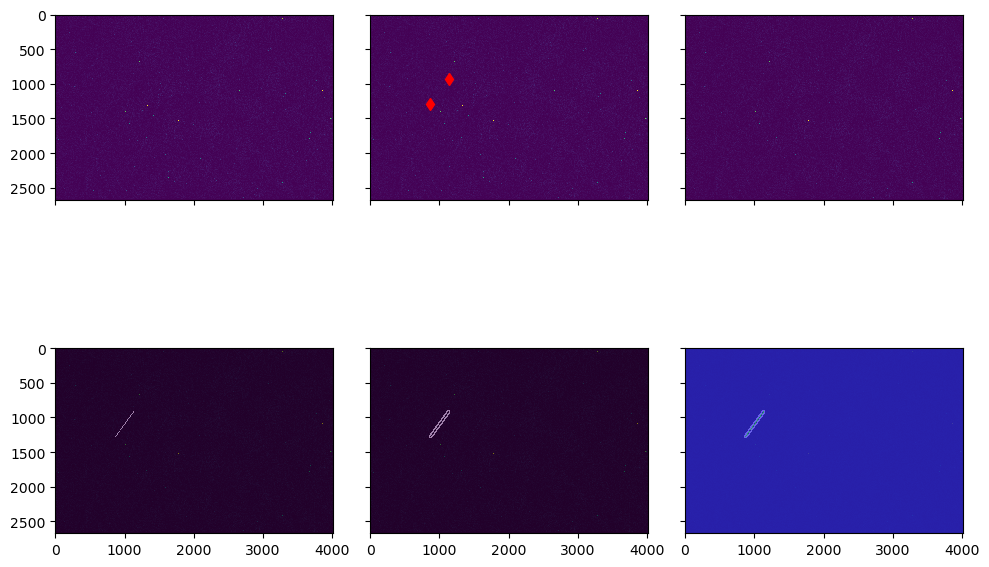

In [11]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=[10,8], sharex=True, sharey=True)

# deltaimage
ax1.imshow(np.fabs(deltaimage), interpolation="none", vmin=0, vmax=1000.)

# endpoints
ax2.imshow(np.fabs(deltaimage), interpolation="none", vmin=0, vmax=1000.)
ax2.plot(x_min, y_min, 'd', color='red')
ax2.plot(x_max, y_max, 'd', color='red')

# starsmaskedimage
ax3.imshow(np.fabs(maskedstarimage), interpolation="none", vmin=0, vmax=1000.)

# satmaskedimage
ax4.imshow(np.fabs(maskedstarimage), interpolation="none", vmin=0, vmax=1000.)
ax4.imshow(sat_mask, interpolation="none", vmin=0, vmax=1, cmap='binary_r', alpha=0.5)

# skymaskedimage
ax5.imshow(np.fabs(maskedstarimage), interpolation="none", vmin=0, vmax=1000.)
ax5.imshow(outer_skymask, interpolation="none", vmin=0, vmax=1, cmap='binary_r', alpha=0.5)

# all together
ax6.imshow(np.fabs(maskedstarimage), interpolation='none', vmin=0, vmax=1000)
ax6.imshow(linemask, interpolation="none", vmin=0, vmax=1, cmap='binary', alpha=0.5)
ax6.imshow(outer_skymask, interpolation="none", vmin=0, vmax=1, cmap='binary_r', alpha=0.5)
ax6.imshow(sat_mask, interpolation="none", vmin=0, vmax=1, cmap='winter', alpha=0.5)

# for ax in fig.axes:
#     ax.axis('off')

plt.tight_layout()
plt.show()

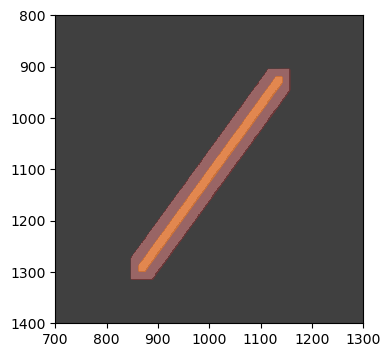

In [12]:
plt.figure(figsize=[8,4])
plt.imshow(outer_skymask, interpolation="none", vmin=0, vmax=1, cmap='binary_r', alpha=0.5, zorder=1)
plt.imshow(inner_skymask, interpolation="none", vmin=0, vmax=1, cmap='binary_r', alpha=0.5, zorder=1)

idx_outer = np.where(outer_skymask == 1)
plt.plot(idx_outer[1], idx_outer[0], alpha=0.3, c='C3', zorder=2)

idx_inner = np.where(inner_skymask == 1)
plt.plot(idx_inner[1], idx_inner[0], alpha=0.5, c='C1', zorder=3)

plt.xlim([700,1300])
plt.ylim([1400,800])
plt.show()

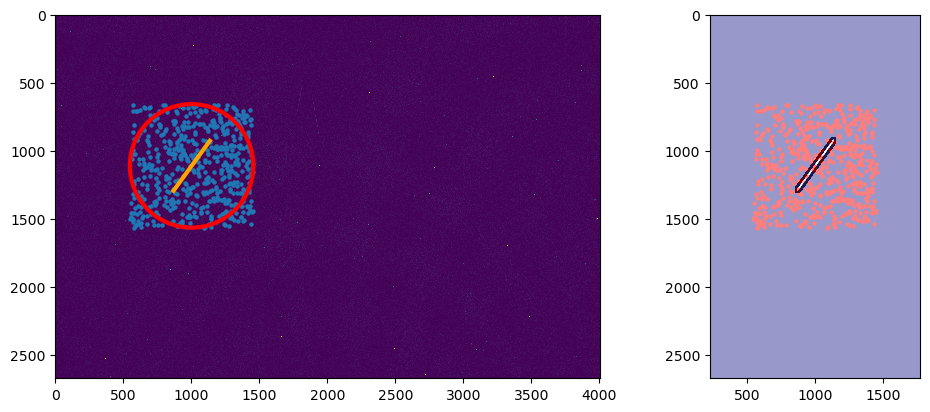

In [13]:
# selectedstarsimage

# The rectangular region is related to the projection of the circular region of stars onto the 2D image plane, 
# accounting for the distortions caused by the chosen projection

fig = plt.figure(figsize=[10,6])

ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=2, rowspan=2)
ax2 = plt.subplot2grid((3, 3), (0, 2), rowspan=2)

ax1.imshow(np.fabs(maskedstarimage), interpolation="none", vmin=0, vmax=1000., zorder=1)
ax1.scatter(stars_x0[select_stars], stars_y0[select_stars], s=5, zorder=2)

circle = plt.Circle((a, b), n_pixels, ec='r', fc='none', zorder=3, lw=3)
ax1.add_patch(circle)

ax1.plot(x, y, c='orange', zorder=4, lw=3)

ax2.imshow(sat_mask, interpolation="none", vmin=0, vmax=1, cmap='terrain')
ax2.scatter(stars_x0[select_stars], stars_y0[select_stars], s=5, c='red', zorder=1)
ax2.imshow(outer_skymask, interpolation="none", vmin=0, vmax=1, cmap='binary', alpha=0.5, zorder=2)
ax2.axis([int(x_min-2.*n_pixels), int(x_max+2.*n_pixels), int(y_min-2.*n_pixels), int(y_max+2.*n_pixels)])
ax2.invert_yaxis()
ax2.set_ylim(ax1.get_ylim())

plt.tight_layout()
plt.show()

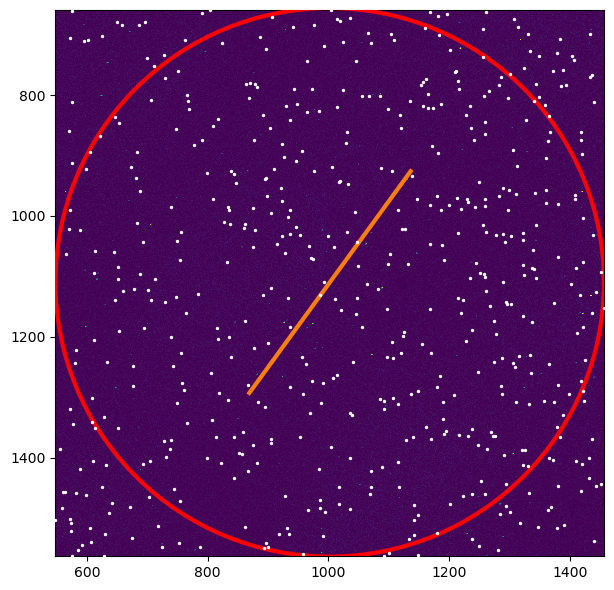

In [14]:
plt.figure(figsize=[10,6])

# Delta Image
plt.imshow(np.fabs(maskedstarimage), interpolation="none", vmin=0, vmax=1000., zorder=1)
plt.scatter(stars_x0[select_stars], stars_y0[select_stars], c='w', s=2, zorder=4)

# Star annulus
circle = plt.Circle((a, b), n_pixels, ec='r', fc='none', zorder=3, lw=3)
plt.gca().add_patch(circle)

# Satellite trail
plt.plot(x, y, c='C1', zorder=3, lw=3)

xlim = [min(stars_x0[select_stars]), max(stars_x0[select_stars])]
ylim = [min(stars_y0[select_stars]), max(stars_y0[select_stars])]
plt.xlim(xlim)
plt.ylim(ylim)
plt.gca().invert_yaxis()

plt.tight_layout()
# plt.savefig(f'{savedir}star_annulus_orig.png', dpi=300, bbox_inches='tight')
plt.show()

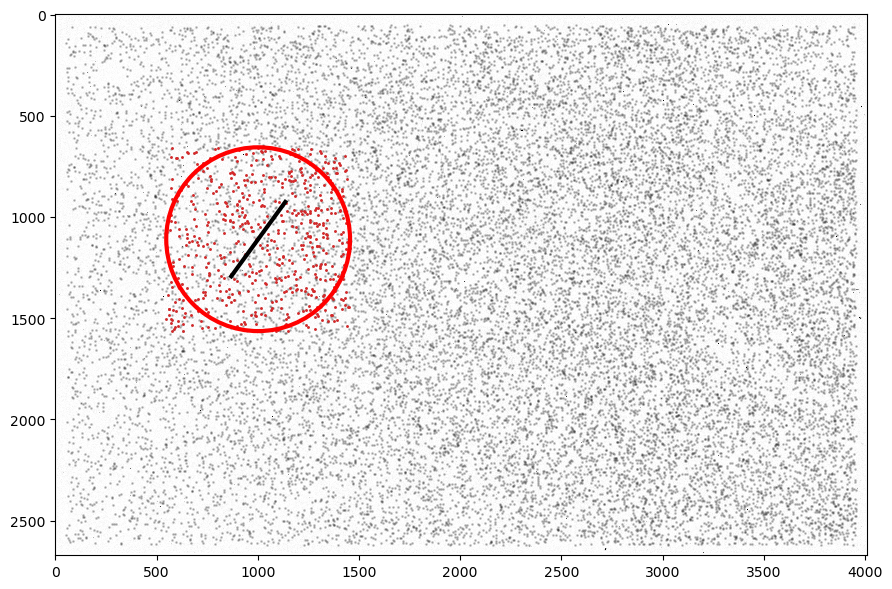

In [15]:
# selectedstarsimage

# select_stars = np.where(np.in1d(np.round(stars_x0).astype(int), 
#                                 np.argwhere(starsmask==1)[:,1]) & np.in1d(np.round(stars_y0).astype(int), 
#                                 np.argwhere(starsmask==1)[:,0]) & (starcat['vmag'][stars_err0] <= 9.0))[0]


plt.figure(figsize=[10,6])
plt.imshow(np.fabs(maskedstarimage), interpolation="none", vmin=0, vmax=1000., cmap='binary', zorder=1)
plt.scatter(stars_x0[select_stars], stars_y0[select_stars], c='C3', s=1, zorder=2)
plt.scatter(stars_x0, stars_y0, s=1, c='k', zorder=1, alpha=0.2)

circle = plt.Circle((a, b), n_pixels, ec='r', fc='none', zorder=3, lw=3)
plt.gca().add_patch(circle)

plt.plot(x, y, c='k', zorder=4, lw=3)

plt.tight_layout()
# plt.savefig(f'{savedir}all_stars_orig.png', dpi=300, bbox_inches='tight')
plt.show()

In [41]:
# The fluxes of the surrounding stars have been determined as part of standard MASCARA/BRING data reduction. 
# We read in the files that contain these values and use ascc values to identify the surrounding stars.

vmag_list = starcat['vmag'][select_stars]
ascc_list = starcat['ascc'][select_stars]

starsflux = []
starsvmag = []      
for vm, ascc in enumerate(ascc_list):

    try:            
        lc = fast['lightcurves/'+str(ascc)]
        # select the 50 data points that are in the same 5 minutes sequence to allow some averaging
        select = np.where((lc['lstseq'] % 13500)%270 == (curlstseq %13500) % 270) 
        if (4 <= vmag_list[vm] <= 6): 
            if (not np.isnan(np.median(lc['flux1'][select])) and (not np.isinf(np.median(lc['flux1'][select])))):
                starsflux.append(np.log10(np.median(lc['flux1'][select])))
                starsvmag.append(vmag_list[vm])
                     
    except KeyError:
        # Apparently the flux is not determined for all stars in the image
        continue
        
starsflux = np.array(starsflux)
starsvmag = np.array(starsvmag)

# Went back and corrected mistake of using n_pixels as the radius

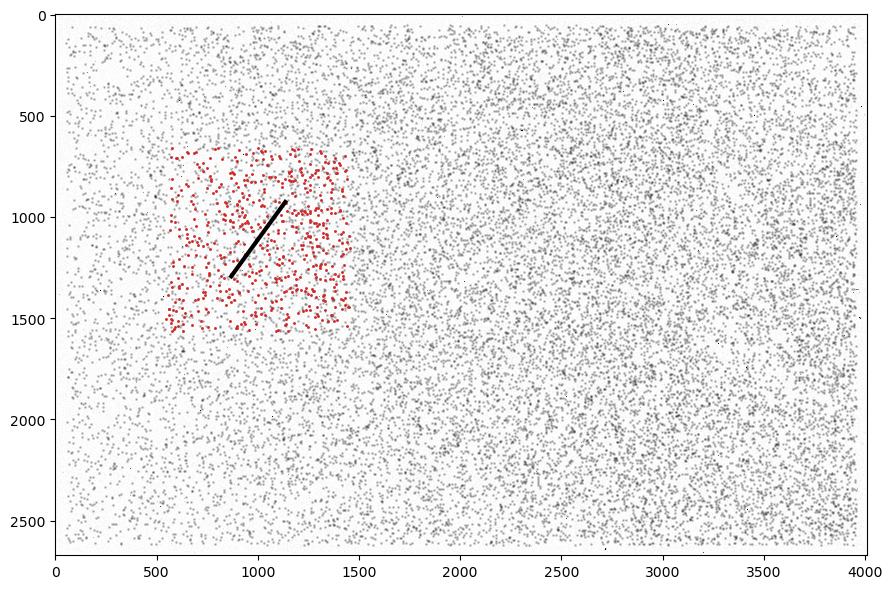

In [16]:
# selectedstarsimage

# select_stars = np.where(np.in1d(np.round(stars_x0).astype(int), 
#                                 np.argwhere(starsmask==1)[:,1]) & np.in1d(np.round(stars_y0).astype(int), 
#                                 np.argwhere(starsmask==1)[:,0]) & (starcat['vmag'][stars_err0] <= 9.0))[0]


plt.figure(figsize=[10,6])
plt.imshow(np.fabs(maskedstarimage), interpolation="none", vmin=0, vmax=1000., cmap='binary', zorder=1)
plt.scatter(stars_x0[select_stars], stars_y0[select_stars], c='C3', s=1, zorder=2)
plt.scatter(stars_x0, stars_y0, s=1, c='k', zorder=1, alpha=0.2)

plt.plot(x, y, c='k', zorder=4, lw=3)

plt.tight_layout()
# plt.savefig(f'{savedir}all_stars_new.png', dpi=300, bbox_inches='tight')
plt.show()

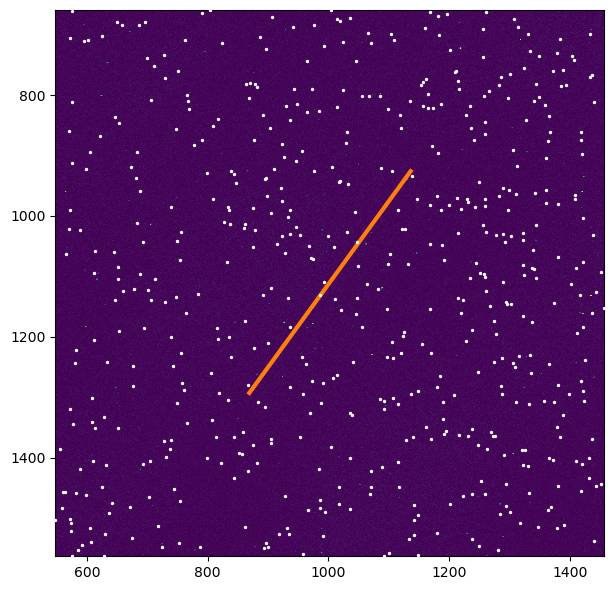

In [17]:
plt.figure(figsize=[10,6])

# Delta Image
plt.imshow(np.fabs(maskedstarimage), interpolation="none", vmin=0, vmax=1000., zorder=1)
plt.scatter(stars_x0[select_stars], stars_y0[select_stars], c='w', s=2, zorder=4)

# Satellite trail
plt.plot(x, y, c='C1', zorder=3, lw=3)

xlim = [min(stars_x0[select_stars]), max(stars_x0[select_stars])]
ylim = [min(stars_y0[select_stars]), max(stars_y0[select_stars])]
plt.xlim(xlim)
plt.ylim(ylim)
plt.gca().invert_yaxis()

plt.tight_layout()
# plt.savefig(f'{savedir}star_annulus_new.png', dpi=300, bbox_inches='tight')
plt.show()

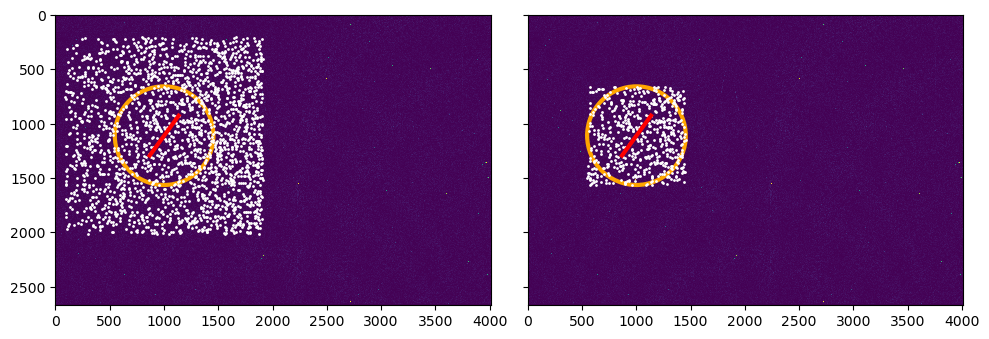

In [18]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=[10,6], sharey=True)



a,b = int(round((x_min+x_max)/2.)), int(round((y_min+y_max)/2.))
yy, xx = np.meshgrid(np.linspace(0, emptymask.shape[0]-1, emptymask.shape[0]),
                     np.linspace(0, emptymask.shape[1]-1, emptymask.shape[1]))
starsmask = emptymask.copy()
starsmask[np.where((xx-a)**2.+(yy-b)**2. <= (4*n_pixels*n_pixels))[1], 
          np.where((xx-a)**2.+(yy-b)**2. <= (4*n_pixels*n_pixels))[0]]=1
select_stars = np.where(np.in1d(np.round(stars_x0).astype(int), 
                                np.argwhere(starsmask==1)[:,1]) & np.in1d(np.round(stars_y0).astype(int), 
                                np.argwhere(starsmask==1)[:,0]) & (starcat['vmag'][stars_err0] <= 9.0))[0]

ax1.imshow(np.fabs(maskedstarimage), interpolation="none", vmin=0, vmax=1000., zorder=1)
ax1.scatter(stars_x0[select_stars], stars_y0[select_stars], c='w', s=1, zorder=2)




a,b = int(round((x_min+x_max)/2.)), int(round((y_min+y_max)/2.))
yy, xx = np.meshgrid(np.linspace(0, emptymask.shape[0]-1, emptymask.shape[0]),
                     np.linspace(0, emptymask.shape[1]-1, emptymask.shape[1]))
starsmask = emptymask.copy()
radius = int(round(n_pixels/2.))
starsmask[np.where((xx-a)**2.+(yy-b)**2. <= (4*radius*radius))[1], 
          np.where((xx-a)**2.+(yy-b)**2. <= (4*radius*radius))[0]]=1
select_stars = np.where(np.in1d(np.round(stars_x0).astype(int), 
                                np.argwhere(starsmask==1)[:,1]) & np.in1d(np.round(stars_y0).astype(int), 
                                np.argwhere(starsmask==1)[:,0]) & (starcat['vmag'][stars_err0] <= 9.0))[0]

ax2.imshow(np.fabs(maskedstarimage), interpolation="none", vmin=0, vmax=1000., zorder=1)
ax2.scatter(stars_x0[select_stars], stars_y0[select_stars], c='w', s=1, zorder=2)



# Satellite trail
ax1.plot(x, y, c='r', zorder=3, lw=3)
ax2.plot(x, y, c='r', zorder=3, lw=3)


circle1 = plt.Circle((a, b), n_pixels, ec='orange', fc='none', zorder=1, lw=3)
ax1.add_patch(circle1)
circle2 = plt.Circle((a, b), n_pixels, ec='orange', fc='none', zorder=1, lw=3)
ax2.add_patch(circle2)


plt.tight_layout()
# plt.savefig(f'{savedir}star_annulus_mistake.png', dpi=300, bbox_inches='tight')
plt.show()

## So, we could say that this Starlink trail could affect all pixels within this annulus

In [19]:
# Annulus dimensions

ax_min, ax_max = min(stars_x0[select_stars]), max(stars_x0[select_stars]) 
ay_min, ay_max = min(stars_y0[select_stars]), max(stars_y0[select_stars])

x_length = int(round(ax_max - ax_min) + 1)
y_length = int(round(ay_max - ay_min) + 1)

print(x_length, y_length)

affected_area = x_length * y_length
image_area = nx * ny

print(f'{affected_area} pixels of {image_area} affected')
print(f'{(affected_area/image_area) * 100} %')

909 905
822645 pixels of 10709376 affected
7.681539988884506 %


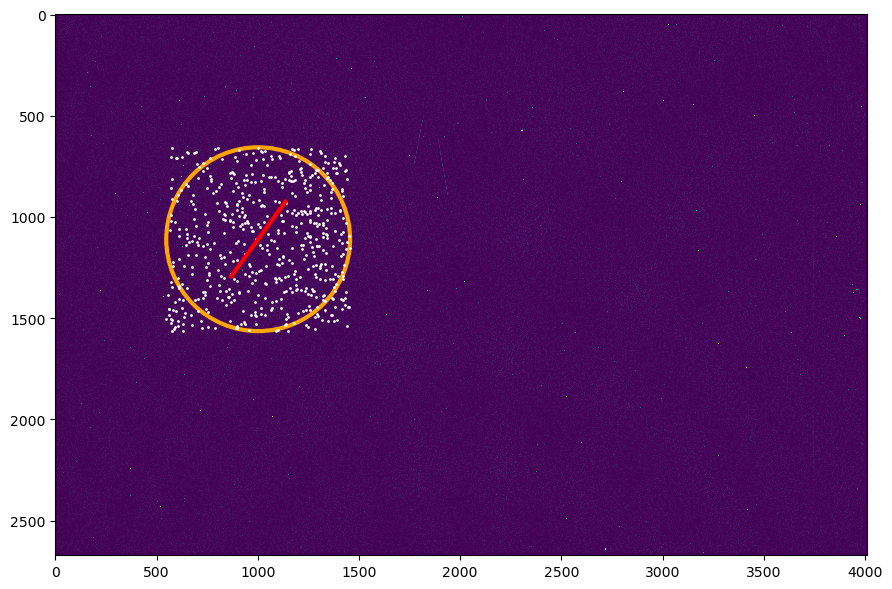

In [20]:
fig, ax = plt.subplots(1, 1, figsize=[10,6], sharey=True)
ax.imshow(np.fabs(maskedstarimage), interpolation="none", vmin=0, vmax=1000., zorder=1)
ax.scatter(stars_x0[select_stars], stars_y0[select_stars], c='w', s=1, zorder=2)
ax.plot(x, y, c='r', zorder=3, lw=3)
circle = plt.Circle((a, b), n_pixels, ec='orange', fc='none', zorder=1, lw=3)
ax.add_patch(circle)

plt.tight_layout()
# plt.savefig(f'{savedir}star_annulus.png', dpi=300, bbox_inches='tight')
plt.show()

# The annulus is too big I think.. over-estimating the area affected

446 455
202930 pixels of 10709376 affected
1.8948816438978329 %


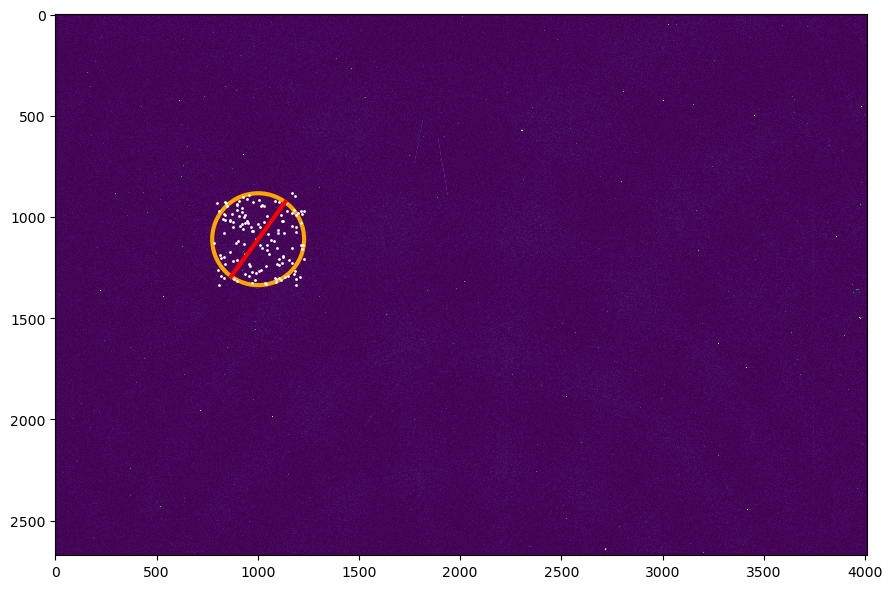

In [21]:
def smaller_star_annulus():

    fig, ax = plt.subplots(1, 1, figsize=[10,6], sharey=True)

    a,b = int(round((x_min+x_max)/2.)), int(round((y_min+y_max)/2.))
    yy, xx = np.meshgrid(np.linspace(0, emptymask.shape[0]-1, emptymask.shape[0]),
                         np.linspace(0, emptymask.shape[1]-1, emptymask.shape[1]))
    starsmask = emptymask.copy()
    radius = int(round(n_pixels/2.))
    starsmask[np.where((xx-a)**2.+(yy-b)**2. <= (radius*radius))[1], 
              np.where((xx-a)**2.+(yy-b)**2. <= (radius*radius))[0]]=1
    select_stars = np.where(np.in1d(np.round(stars_x0).astype(int), 
                                    np.argwhere(starsmask==1)[:,1]) & np.in1d(np.round(stars_y0).astype(int), 
                                    np.argwhere(starsmask==1)[:,0]) & (starcat['vmag'][stars_err0] <= 9.0))[0]

    ax.imshow(np.fabs(maskedstarimage), interpolation="none", vmin=0, vmax=1000., zorder=1)
    ax.scatter(stars_x0[select_stars], stars_y0[select_stars], c='w', s=1, zorder=2)
    ax.plot(x, y, c='r', zorder=3, lw=3)
    circle = plt.Circle((a, b), radius, ec='orange', fc='none', zorder=1, lw=3)
    ax.add_patch(circle)
    
    # Annulus dimensions
    ax_min, ax_max = min(stars_x0[select_stars]), max(stars_x0[select_stars]) 
    ay_min, ay_max = min(stars_y0[select_stars]), max(stars_y0[select_stars])
    x_length = int(round(ax_max - ax_min) + 1)
    y_length = int(round(ay_max - ay_min) + 1)
    print(x_length, y_length)

    affected_area = x_length * y_length
    image_area = nx * ny

    print(f'{affected_area} pixels of {image_area} affected')
    print(f'{(affected_area/image_area) * 100} %')

    plt.tight_layout()
    # plt.savefig(f'{savedir}star_annulus.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    
smaller_star_annulus()

## Still ~ 10 times larger than expected.. (20000 pixels)

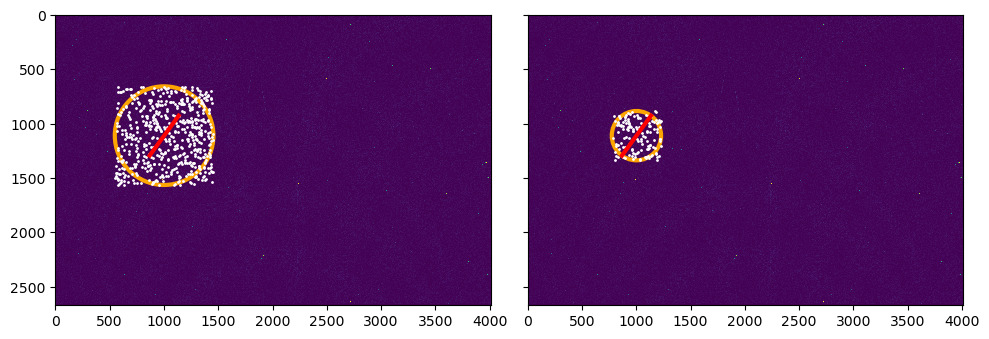

In [22]:
def comparsion():
    
    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=[10,6], sharey=True)

    a,b = int(round((x_min+x_max)/2.)), int(round((y_min+y_max)/2.))
    yy, xx = np.meshgrid(np.linspace(0, emptymask.shape[0]-1, emptymask.shape[0]),
                         np.linspace(0, emptymask.shape[1]-1, emptymask.shape[1]))
    starsmask = emptymask.copy()
    radius = int(round(n_pixels/2.))
    starsmask[np.where((xx-a)**2.+(yy-b)**2. <= (4*radius*radius))[1], 
              np.where((xx-a)**2.+(yy-b)**2. <= (4*radius*radius))[0]]=1
    select_stars = np.where(np.in1d(np.round(stars_x0).astype(int), 
                                    np.argwhere(starsmask==1)[:,1]) & np.in1d(np.round(stars_y0).astype(int), 
                                    np.argwhere(starsmask==1)[:,0]) & (starcat['vmag'][stars_err0] <= 9.0))[0]

    ax1.imshow(np.fabs(maskedstarimage), interpolation="none", vmin=0, vmax=1000., zorder=1)
    ax1.scatter(stars_x0[select_stars], stars_y0[select_stars], c='w', s=1, zorder=2)
    ax1.plot(x, y, c='r', zorder=3, lw=3)
    circle = plt.Circle((a, b), n_pixels, ec='orange', fc='none', zorder=1, lw=3)
    ax1.add_patch(circle)



    a,b = int(round((x_min+x_max)/2.)), int(round((y_min+y_max)/2.))
    yy, xx = np.meshgrid(np.linspace(0, emptymask.shape[0]-1, emptymask.shape[0]),
                         np.linspace(0, emptymask.shape[1]-1, emptymask.shape[1]))
    starsmask = emptymask.copy()
    radius = int(round(n_pixels/2.))
    starsmask[np.where((xx-a)**2.+(yy-b)**2. <= (radius*radius))[1], 
              np.where((xx-a)**2.+(yy-b)**2. <= (radius*radius))[0]]=1
    select_stars = np.where(np.in1d(np.round(stars_x0).astype(int), 
                                    np.argwhere(starsmask==1)[:,1]) & np.in1d(np.round(stars_y0).astype(int), 
                                    np.argwhere(starsmask==1)[:,0]) & (starcat['vmag'][stars_err0] <= 9.0))[0]

    ax2.imshow(np.fabs(maskedstarimage), interpolation="none", vmin=0, vmax=1000., zorder=1)
    ax2.scatter(stars_x0[select_stars], stars_y0[select_stars], c='w', s=1, zorder=2)
    ax2.plot(x, y, c='r', zorder=3, lw=3)
    circle2 = plt.Circle((a, b), radius, ec='orange', fc='none', zorder=1, lw=3)
    ax2.add_patch(circle2)

    plt.tight_layout()
#     plt.savefig(f'{savedir}star_annulus_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    

comparsion()

## Should we further reduce the stars we select? I.e. such that they would be considered stars we'd care about for transit events, so perhaps limited to certain magnitude range

# Oh, maybe we should be looking at the annulus used to select the satellite..

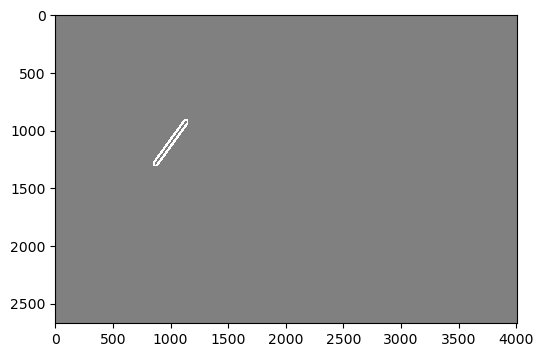

In [23]:
plt.figure(figsize=[8,4])
# plt.imshow(np.fabs(maskedstarimage), interpolation='none', vmin=0, vmax=1000)
# plt.imshow(linemask, interpolation="none", vmin=0, vmax=1, cmap='binary', alpha=0.5)
plt.imshow(outer_skymask, interpolation="none", vmin=0, vmax=1, cmap='binary_r', alpha=0.5)
# plt.imshow(sat_mask, interpolation="none", vmin=0, vmax=1, cmap='winter', alpha=0.5)
plt.show()

Width: 308
Height: 408
Area: 125664


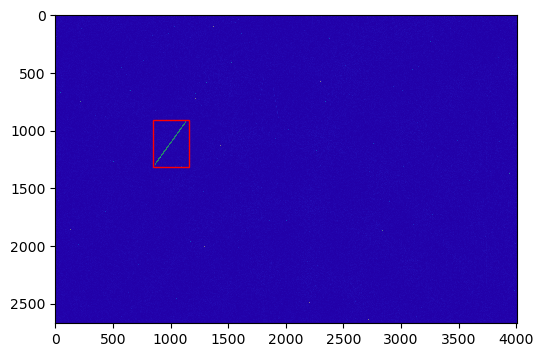

In [24]:
def dimensions_of_satmask(mask_region):

    # Find the indices where the value is 1
    indices = np.where(mask_region == 1)

    # Determine the boundaries of the rectangle
    x_min, x_max = np.min(indices[1]), np.max(indices[1])
    y_min, y_max = np.min(indices[0]), np.max(indices[0])

    # Calculate the width and height
    width = x_max - x_min + 1
    height = y_max - y_min + 1

    # Calculate the area
    area = width * height

    print("Width:", width)
    print("Height:", height)
    print("Area:", area)
    
    plt.figure(figsize=[8,4])
    plt.imshow(np.fabs(maskedstarimage), interpolation='none', vmin=0, vmax=1000)
    plt.imshow(sat_mask, interpolation="none", vmin=0, vmax=1, cmap='winter', alpha=0.5)
    rect = plt.Rectangle((x_min, y_min), width, height, fc='none', ec='r')
    plt.gca().add_patch(rect)
    plt.show()
    

dimensions_of_satmask(outer_skymask)

Width: 275
Height: 375
Area: 103125


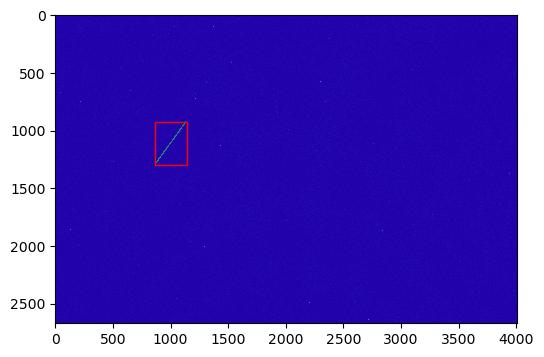

In [310]:
dimensions_of_satmask(sat_mask)

# No, rectangle over-estimates. Maybe do it by counting pixels?

In [25]:
np.sum(outer_skymask == 1)

20580

## But should I also add the pixels from the trail itself? I think so..

In [26]:
np.sum(outer_skymask==1) + np.sum(sat_mask==1)

25501

## This may leave out some pixels. Need a method for finding the area enclosed in a irregularly shaped polygon

To calculate the area of a closed polygon represented by an irregular shape in a multidimensional array, you can use the **shoelace formula**. This formula calculates the signed area of a polygon defined by its vertices. Here's how you can apply the shoelace formula:

1. Identify the vertices of the polygon by finding the coordinates where the value is 1 in the multidimensional array.
2. Reorder the vertices in a counterclockwise or clockwise direction.
3. Apply the shoelace formula to calculate the area.

The shoelace formula involves taking the dot product of the x and y coordinates, and subtracting the reversed dot product, followed by taking the absolute value and halving the result. BUT:

 - The shoelace formula assumes that the vertices of the polygon are ordered in either clockwise or counterclockwise direction. 
 - The vertices extracted from the array may not be in the desired order.
 - To ensure the correct ordering of the vertices, you can use the convex_hull function from the scipy.spatial module.
 - This function calculates the convex hull of a set of points and returns the vertices in counterclockwise order.
 
**The convex hull of a set of points is the smallest convex polygon that encloses all the points in the set.** In other words, it is the shape formed by connecting the outermost points of the set in a way that the polygon's angles are all less than 180 degrees. The concept of the convex hull is analogous to wrapping a rubber band around a set of points on a plane. The resulting shape of the stretched rubber band represents the convex hull of those points. The convex hull has several properties:

- It is convex: This means that any line segment connecting two points within the convex hull lies entirely inside the hull.
- It encloses all the points: Every point in the set lies either on the boundary or inside the convex hull.
- It has the minimum possible area: Among all possible convex polygons that enclose the points, the convex hull has the smallest area.

Calculating the convex hull of the vertices extracted from the multidimensional array helps to ensure that the vertices are ordered in a counterclockwise manner, which is necessary for correctly calculating the area using the shoelace formula.

In [320]:
from scipy.spatial import ConvexHull

indices  = np.where(outer_skymask == 1)
vertices = np.column_stack((indices[1], indices[0]))  # Reorder vertices as (x, y) pairs

# Calculate the convex hull of the vertices
hull = ConvexHull(vertices)

# Extract the vertices in counterclockwise order
ordered_vertices = vertices[hull.vertices]

# Calculate the signed area using the shoelace formula
area = 0.5 * np.abs(np.dot(
    ordered_vertices[:, 0], np.roll(ordered_vertices[:, 1], 1)) - np.dot(
    ordered_vertices[:, 1], np.roll(ordered_vertices[:, 0], 1)))

print(area)

27536.0

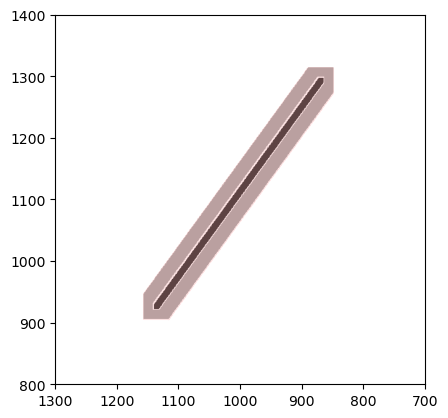

In [31]:
nonzero_indices = np.nonzero(outer_skymask)
x_coords = nonzero_indices[1]
y_coords = nonzero_indices[0]

# Appending the first coordinates to the end to close the loop
x_coords = np.append(x_coords, x_coords[0])
y_coords = np.append(y_coords, y_coords[0])

# Plot the shape and the coordinates
fig, ax = plt.subplots()
ax.imshow(outer_skymask, cmap='binary', zorder=2, alpha=0.3)
ax.plot(x_coords, y_coords, alpha=0.1, zorder=3, c='r')
plt.xlim([1300,700])
plt.ylim([800,1400])

ax.imshow(sat_mask, cmap='binary', zorder=1)

plt.show()

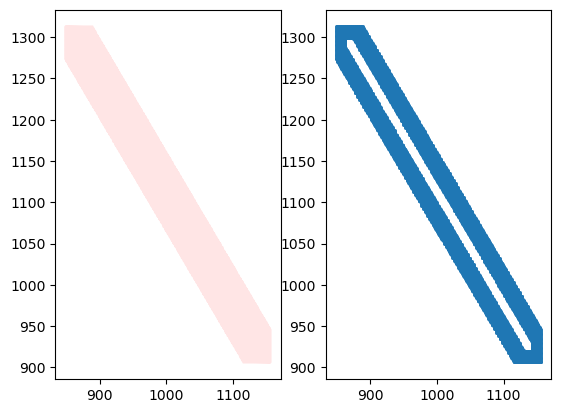

In [33]:
nonzero_indices = np.nonzero(outer_skymask)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(nonzero_indices[1], nonzero_indices[0], alpha=0.1, c='r')
ax2.scatter(nonzero_indices[1], nonzero_indices[0], s=1)
plt.show()

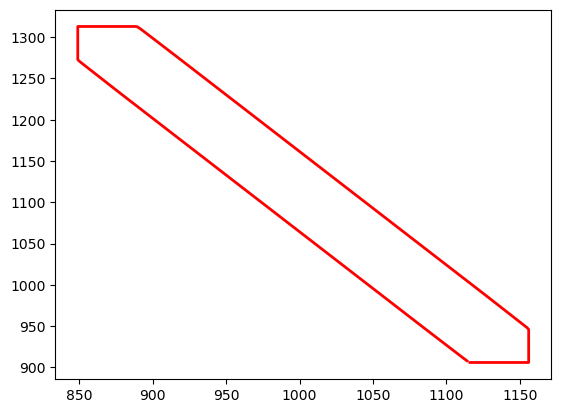

In [435]:
plt.figure()

indices = np.where(outer_skymask == 1)
vertices = np.column_stack((indices[1], indices[0]))  # Reorder vertices as (x, y) pairs

# Calculate the convex hull of the vertices
hull = ConvexHull(vertices)

# Extract the vertices in counterclockwise order
ordered_vertices = vertices[hull.vertices]

plt.plot(ordered_vertices[:, 0], ordered_vertices[:, 1], 'r-', linewidth=2)

plt.show()

In [440]:
def shoelace_area(vertices):
    n = len(vertices)
    area = 0.0

    for i in range(n):
        j = (i + 1) % n
        area += vertices[i, 0] * vertices[j, 1] - vertices[j, 0] * vertices[i, 1]

    print(abs(area) / 2.0)


shoelace_area(ordered_vertices)

27536.0


In [441]:
from shapely.geometry import Polygon
shapley_polygon = Polygon(ordered_vertices)
shapley_polygon.area

27536.0

# okay, we can use Convex Hull from scipy and Polygon from shapely

27536 pixels of 10709376 affected
0.257%


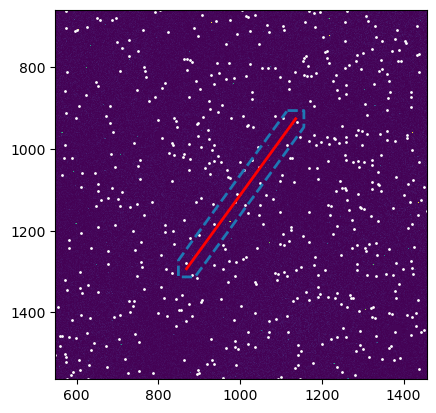

In [34]:
def polygon_area(mask_region):
    
    from scipy.spatial import ConvexHull
    from shapely.geometry import Polygon

    indices = np.where(mask_region == 1)
    vertices = np.column_stack((indices[1], indices[0]))  # Reorder vertices as (x, y) pairs

    # Calculate the convex hull of the vertices
    hull = ConvexHull(vertices)

    # Extract the vertices in counterclockwise order
    ordered_vertices = vertices[hull.vertices]

    shapley_polygon = Polygon(ordered_vertices)
    affected_area = int(round(shapley_polygon.area))
    image_area = nx * ny
    
    print(f'{affected_area} pixels of {image_area} affected')
    print(f'{round((affected_area/image_area) * 100, 3)}%')
    
    
    a,b = int(round((x_min+x_max)/2.)), int(round((y_min+y_max)/2.))
    yy, xx = np.meshgrid(np.linspace(0, emptymask.shape[0]-1, emptymask.shape[0]),
                         np.linspace(0, emptymask.shape[1]-1, emptymask.shape[1]))
    starsmask = emptymask.copy()
    radius = int(round(n_pixels/2.))
    starsmask[np.where((xx-a)**2.+(yy-b)**2. <= (4*radius*radius))[1], 
              np.where((xx-a)**2.+(yy-b)**2. <= (4*radius*radius))[0]]=1
    select_stars = np.where(np.in1d(np.round(stars_x0).astype(int), 
                                    np.argwhere(starsmask==1)[:,1]) & np.in1d(np.round(stars_y0).astype(int), 
                                    np.argwhere(starsmask==1)[:,0]) & (starcat['vmag'][stars_err0] <= 9.0))[0]

    
    plt.figure()
    plt.imshow(np.fabs(maskedstarimage), interpolation="none", vmin=0, vmax=1000., zorder=1)
    plt.scatter(stars_x0[select_stars], stars_y0[select_stars], c='w', s=1, zorder=2)
    plt.plot(x, y, c='r', zorder=3, lw=2)
    
    ylim = [max(stars_y0[select_stars]), min(stars_y0[select_stars])]
    xlim = [min(stars_x0[select_stars]), max(stars_x0[select_stars])]
    plt.xlim(xlim)
    plt.ylim(ylim)
    
    plt.plot(ordered_vertices[:, 0], ordered_vertices[:, 1], lw=2, ls='--')
    
    plt.show()
    
    
polygon_area(outer_skymask)

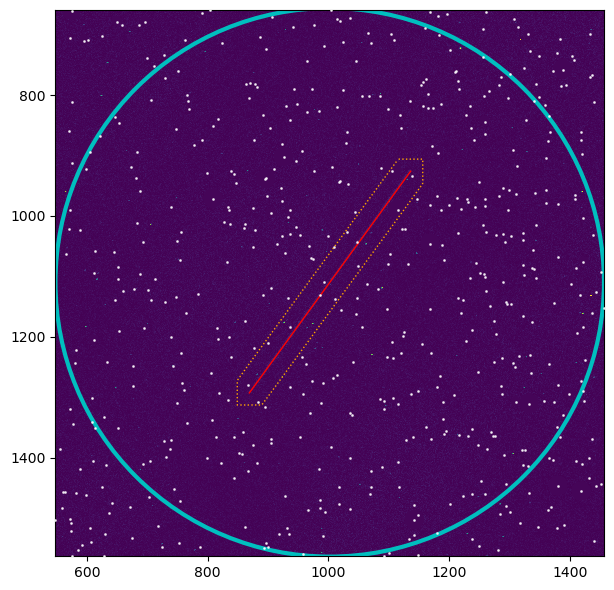

In [37]:
def plot_demo(lim=False):
    from scipy.spatial import ConvexHull
    
    plt.figure(figsize=[10,6])
    name = 'annulus'
    
    indices = np.where(outer_skymask == 1)
    vertices = np.column_stack((indices[1], indices[0]))  # Reorder vertices as (x, y) pairs
    hull = ConvexHull(vertices)
    ordered_vertices = vertices[hull.vertices]
    
    plt.imshow(np.fabs(maskedstarimage), interpolation="none", vmin=0, vmax=1000., zorder=1)
    plt.scatter(stars_x0[select_stars], stars_y0[select_stars], c='w', s=1, alpha=0.75, zorder=3)
    plt.plot(x, y, c='r', zorder=2, lw=1)
    plt.plot(ordered_vertices[:, 0], ordered_vertices[:, 1], lw=1, ls=':', c='orange', zorder=2)

    circle = plt.Circle((a, b), 2*radius, ec='c', fc='none', zorder=2, lw=3)
    plt.gca().add_patch(circle)
    
    if lim:
        ylim = [max(stars_y0[select_stars]), min(stars_y0[select_stars])]
        xlim = [min(stars_x0[select_stars]), max(stars_x0[select_stars])]
        plt.xlim(xlim)
        plt.ylim(ylim)
        name = 'annulus_lim'

    plt.tight_layout()
    #plt.savefig(f'{savedir}star_sat_{name}.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    
plot_demo(lim=True)

# Forgot about the inner mask that was already defined... could just add outer + inner to get area within the annulus!!!

In [38]:
test = np.sum(outer_skymask==1) + np.sum(inner_skymask==1)
print('Difference in methods =', abs(test-27536), 'pixels')

Difference in methods = 76 pixels


In [70]:
# testing with another satellite:

satnum = '51797U'
x = vmags[str(curlstseq)][satnum]['FOTOS']['x']
y = vmags[str(curlstseq)][satnum]['FOTOS']['y']

x_min, x_max = x[0], x[1]
y_min, y_max = y[0], y[1]

# Length of the line segment
n_pixels = int(round(np.sqrt((x_max - x_min)**2.+ (y_max - y_min)**2.)))

# Assuming the line segment is linear
x_values = np.rint(np.linspace(x_min, x_max, n_pixels)).astype(int)
y_values = np.rint(np.linspace(y_min, y_max, n_pixels)).astype(int)

emptymask = np.zeros((deltaimage.shape[0], deltaimage.shape[1]))

linemask = emptymask.copy()
linemask[y_values, x_values]=1

# The inner_skymask is used to 'cut a hole' in the outer_skymask, such that we can select a donutshaped 
# patch of the sky to determine the typical background pixel value

# broaden the line segment by 6.5 pixels in each direction
inner_skymask = scn.filters.convolve(linemask,np.ones((11,11)))
inner_skymask[np.where(inner_skymask >= 1)] = 1

# broaden the line segment by 21 pixels in each direction
outer_skymask = scn.filters.convolve(linemask,np.ones((41,41)))
outer_skymask[np.where(inner_skymask == 1)] = 0
outer_skymask[np.where(outer_skymask >= 1)] = 1

# To determine the satellite flux, we broaden the line segment by 4 pixels in each direction
sat_mask = scn.filters.convolve(linemask,np.ones((8,8)))
sat_mask[np.where(sat_mask >= 1)] = 1

# We use the image in which the stars are masked to determine the typical sky background
skybuf = maskedstarimage[np.where(outer_skymask==1)]

skymod, skysig, skyskew = mmm(skybuf, minsky=0)

# We also used the masked image for the flux of the satellite track. In case the satellite passes in front 
# of a star, we do not want to erroneously count the flux of the star towards the satellite. 
sattrack = maskedstarimage[np.where(sat_mask==1)]

#Total satellite flux, uncorrected for background
uncorrected_sat_flux = np.sum(sattrack)

#In case this was the negative line segment in the difference image
uncorrected_sat_flux *= np.sign(uncorrected_sat_flux)

#Sum over all the pixel and subtract the typical sky background value from each pixelvalue
satflux = np.log10(uncorrected_sat_flux - len(sattrack)*skymod)

28992
29050 pixels of 10709376 affected
0.271%


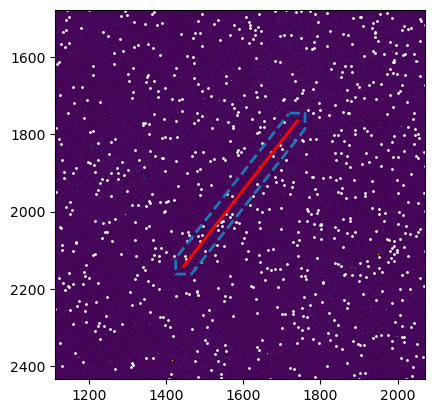

In [72]:
test = np.sum(outer_skymask==1) + np.sum(inner_skymask==1)
print(test)

polygon_area(outer_skymask)

# Why didn't I just define a new mask... 

In [76]:
emptymask = np.zeros((deltaimage.shape[0], deltaimage.shape[1]))

linemask = emptymask.copy()
linemask[y_values, x_values]=1

# broaden the line segment by 21 pixels in each direction
annulus = scn.filters.convolve(linemask, np.ones((41,41)))
annulus[np.where(annulus >= 1)] = 1

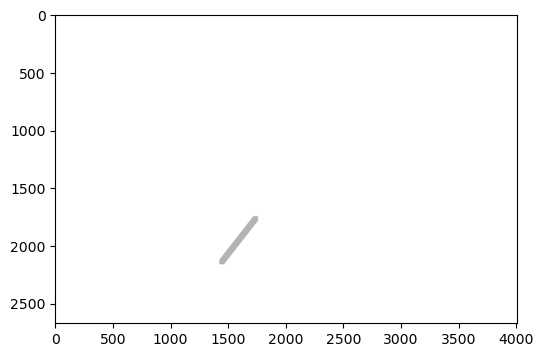

In [77]:
plt.figure(figsize=[8,4])
plt.imshow(annulus, cmap='binary', zorder=2, alpha=0.3)
plt.show()

In [78]:
np.sum(annulus == 1)

28992

### That was incredibly silly of me

In [63]:
def example():
    
    target = '20221023LSC'
    camid = target[-3:]
    masksizes=[2,4,8,16]
    minlinelength=15
    edge=30

    sys.path.append("../mag_errors/")
    from mascommon import mmm

    import bringreduce.configuration as cfg
    cfg.initialize(target)

    import bringreduce.mascara_astrometry as astrometry
    starcat = pf.getdata(cfg.starcat)
    siteinfo = get_siteinfo()

    fast = h5py.File(f"{rootdir}fast_20221023{camid}.hdf5", "r")
    vmags = pd.read_pickle(f'{datadir}vmags_LSC.p')
    files = sorted(glob.glob(f'{testdir}diff_images/LSC/*.fits.gz'))
    
    for f in files:
        lstseq = f[-19:-11]
        data, header = pf.getdata(f, header=True)
        nx = header['XSIZE']
        ny = header['YSIZE']
        JD0 = header['JD0']
        midJD = header['MIDJD']
        midlst = header['MIDLST']
        
        if lstseq not in vmags.keys():
            continue
        
        satnums = list(vmags[lstseq])[2:]
        if len(satnums) == 0:
            continue
            
            print(lstseq)
            for satnum in satnums:
                print(satnum)
                x = vmags[lstseq][satnum]['FOTOS']['x']
                y = vmags[lstseq][satnum]['FOTOS']['y']  
                x_min, x_max = x[0], x[1]
                y_min, y_max = y[0], y[1]
                
                astro, vmag, deltaimage, masksizes, xxx, yyy, stars_x0, stars_y0, stars_err0 = LineSegments(
                    fast, data, nx, ny, starcat, astrometry)
                maskedstarimage, nostarimage, reducedimage = ImageReduction(astro, siteinfo, JD0)
                 
                # Length of the line segment
                n_pixels = int(round(np.sqrt((x_max - x_min)**2.+ (y_max - y_min)**2.)))

                # Assuming the line segment is linear
                x_values = np.rint(np.linspace(x_min, x_max, n_pixels)).astype(int)
                y_values = np.rint(np.linspace(y_min, y_max, n_pixels)).astype(int)
                
                linemask = emptymask.copy()
                linemask[y_values, x_values]=1

                # broaden the line segment by 21 pixels in each direction
                annulus = scn.filters.convolve(linemask, np.ones((41,41)))
                annulus[np.where(annulus >= 1)] = 1
                
                image_area = nx * ny
                affected_area = np.sum(annulus == 1)
                
                print(f'{affected_area} pixels of {image_area} affected')
                print(f'{round((affected_area/image_area) * 100, 3)}%')
            

In [64]:
example()

In [67]:
lstseq = files[0][-19:-11]
lstseq

'48506274'